# Authors:
- Guijas Bravo, Pedro
- Miguélez Millos, Ángel

# 1. Initial setup

First we will configure the environment to have the necessary library dependencies loaded, the dataset (via Google Drive mount) and finally make sure that the GPU of the environment is available. Note that although RNNs are not very parallelizable, tensor operations with GPU increase the computational speed.

### Imports

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras import utils
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

### Load DS Files from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
ds_file_name_path = '/content/drive/MyDrive/Inteligencia Artificial/Teoría/Q2.2/Aprendizaje Profundo/Prácticas/P2/walmart-sales-dataset-of-45stores.csv'
ds_file_name_path = '/content/drive/MyDrive/walmart-sales-dataset-of-45stores.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Set gpu

In [ ]:
def setup_gpu():
  device_name = tf.test.gpu_device_name()
  if device_name == '/device:GPU:0':
    tf.device(device_name)
    print("GPU DETECTED")

setup_gpu()

GPU DETECTED


# 2. Load dataset

Next, the dataset in `.csv` format located in `ds_file_name_path` will be preprocessed. This dataset contains: 
- Store
- Date
- Weekly_Sales (target -> is going to be predicted for the 3rd week after the last element of the sequence)
- Holiday_Flag
- Temperature_Temperature
- Fuel_Price
- CPI
- Unemployment

The code is commented out, however, a quick description of what its main function (`generateTrainTestData`) does is: 

- Loads the `.csv` file with the `readData` function. Additionally it deletes from the feature set the date.

- Then, using the `splitTrainTest` function, the dataset is split into train and test (keeping proportions per store) as well as normalize the information. A dimiensionality is added to the return matrix indicating the store id.

- Finally, for each store (in train and test) data sequences are generated. These sequences will be the samples that will feed the recurrent networks. The function that generates the time-series is `generateTimeSeries`, which essentially delegates the call to a specific function of the `tensorflow` library.
 

In [ ]:
"""
Reads the raw data and encapsulates it in a numpy array, removing the date from the feature set
"""
def readData(fname):
    with open(fname) as f:
        fileData = f.read()
  
    lines = fileData.split("\n")
    header = lines[0].split(",")
    lines = lines[1:] 
    #print(header) 
    #print("Data rows: ", len(lines))

    rawData = np.zeros((len(lines), len(header)-1)) #skip the Date column

    for i, aLine in enumerate(lines):       
        splittedLine = aLine.split(",")[:]
        rawData[i, 0] = splittedLine[0]
        rawData[i, 1:] = [float(x) for x in splittedLine[2:]] 

    return rawData

"""
Splits the dataset keeping the proportion of samples per store in the train and test set. Also add a dimension in the dataset which indicates the store.
Additionally it normalizes using 0 mean normalization and returns the standard deviation of Weekly_Sales.
"""
def splitTrainTest(rawData, testPercent):

    # Compute the amount of train samples (by store)
    listStore = np.unique(rawData[:, 0])
    trainNSamples = np.zeros(len(listStore))
    
    for i, storeId in enumerate(listStore):
        trainNSamples[i] = np.count_nonzero(rawData[:, 0] == storeId)
    print(f"Amount of samples by each store: {trainNSamples}")
    trainNSamples = np.floor((1-testPercent) *  trainNSamples)

    # Get the train data
    tmpTrain = np.zeros((int(np.sum(trainNSamples)), len(rawData[0])))
    store = -1
    counter = 0
    counterTrain = 0
    storeDict = dict(zip(listStore, trainNSamples))
    for i, aLine in enumerate(rawData):
        # Counter reset (assuming store ordering)
        if store != aLine[0]:
            store = int(aLine[0])
            counter = 0
        if(counter < storeDict.get(store)):
            tmpTrain[counterTrain] = rawData[i][:]
            counterTrain += 1
            counter += 1

    # 0 mean normalization over all the dataset
    meanData = tmpTrain.mean(axis=0)
    stdData = tmpTrain.std(axis=0)
    rawNormData = (rawData - meanData) / stdData

    # Get the test and train (again) data
    allTrain = list()
    allTest = list()
    store = -1
    counter = 0
    for i, aLine in enumerate(rawNormData):
        splittedLine = [float(x) for x in aLine[1:]] #skip store id
        # Add store samples (assuming store ordering)
        if store != rawData[i][0]:
            if i != 0:
                allTrain.append(storeDataTrain)
                allTest.append(storeDataTest)
            store = int(rawData[i][0])
            storeDataTrain = list()
            storeDataTest = list()
            counter = 0

        if(counter < storeDict.get(store)):
            storeDataTrain.append(splittedLine)
            counter += 1
        else:
            storeDataTest.append(splittedLine)

        if i == len(rawNormData)-1:
            allTrain.append(storeDataTrain)
            allTest.append(storeDataTest)

    return allTrain, allTest, stdData[1] #std of wSales

"""
Generates a time series given the input and ouput data
"""
def generateTimeSeries(data, wSales, seqLength, batchSize):   
    sampling_rate = 1 #keep all the data points 
    weeksInAdvance = 3
    delay = sampling_rate * (seqLength + weeksInAdvance - 1) #the target will be the weekly sales in 2 weeks
    
    dataset = keras.utils.timeseries_dataset_from_array(
        data[:-delay],
        targets=wSales[delay:],
        sampling_rate=sampling_rate,
        sequence_length=seqLength,
        shuffle=True,
        batch_size=batchSize,
        start_index=0)
    
    return dataset

"""
Processes the raw dataset, returning the train and test time series dataset, the standard deviation of Weekly_Sales and the number of features.
"""
def generateTrainTestData(fileName, testPercent, seqLength, batchSize):
    rawData = readData(fileName)
    allTrain, allTest, stdSales = splitTrainTest(rawData, testPercent)

    print(f"{np.array(allTrain).shape=}\n{np.array(allTest).shape=}")
    
    # Generate time series samples 
    for i in range(len(allTrain)): # iterating stores
        tmp_train = generateTimeSeries(np.array(allTrain[i]), np.array(allTrain[i])[:,0], seqLength, batchSize)
        tmp_test = generateTimeSeries(np.array(allTest[i]), np.array(allTest[i])[:,0], seqLength, batchSize)

        if i == 0:
            train_dataset = tmp_train
            test_dataset = tmp_test
        else:
            train_dataset = train_dataset.concatenate(tmp_train)
            test_dataset = test_dataset.concatenate(tmp_test)
    
    return train_dataset, test_dataset, stdSales, np.shape(allTrain)[2]


In [ ]:
testPercent = 0.2
seqLength = 14
batchSize = 1
trainData, testData, stdSales, nFeatures = generateTrainTestData(ds_file_name_path, testPercent, seqLength, batchSize) 
print(f"{stdSales=}")
print(f"{nFeatures=}")

Amount of samples by each store: [143. 143. 143. 143. 143. 143. 143. 143. 143. 143. 143. 143. 143. 143.
 143. 143. 143. 143. 143. 143. 143. 143. 143. 143. 143. 143. 143. 143.
 143. 143. 143. 143. 143. 143. 143. 143. 143. 143. 143. 143. 143. 143.
 143. 143. 143.]
np.array(allTrain).shape=(45, 114, 6)
np.array(allTest).shape=(45, 29, 6)
stdSales=571854.7800576452
nFeatures=6


# 3. Train and evaluate the model

In this section the training process will be defined and different experiments with multiple networks and recurrent architectures will be performed. Note that recurrent networks will be used because of their ability by design to handle data sequences. Specifically, three types of recurrent networks will be considered:

- Recurrent Neural Network (RNN): it is the most basic type of recurrent networks, containing links between the previous predictions and the current prediction. This link is what makes it suitable to model temporal data, since the previous information is used to predict the next output.

- Long-Short Term Memory (LSTM): it aims to solving the problem by design of the RNNs in which the information from a specific timestep vanishes as the time passes by due to the gradient calculation over time (new activations overwrite activations from previous cells). Therefore, it is told to provide long-term memory to the network. It is designed with a series of gates that selectively choose the information from the past to be kept and the one to be forgotten.

- Gated Reccurent Unit (GRU): it can be seen as a simpler LSTM. It also contains gates to select the information but using less operations. Because of this, they are faster and consume less memory than a LSTM.


Additionally, note the parameterization allowed by the `create_model` function.

In [ ]:
def create_model(recurrent_unit=layers.LSTM, cell_units=[64,64], dropout=(0.,0.,0.), hidden_layer=None, regularization=(0,0)):
  # Input
  inputs = keras.Input(shape=(seqLength, nFeatures))

  # Recurrent layers
  lstm_dropout, recurrent_dropuot, dense_dropout = dropout
  for i, units in enumerate(cell_units):
    if i==0:
      # First RNN layer
      x = recurrent_unit(units, return_sequences=len(cell_units[i:]) != 1, recurrent_dropout=recurrent_dropuot, dropout=lstm_dropout, kernel_regularizer=regularizers.L1L2(l1=regularization[0], l2=regularization[1]))(inputs)
    else:
      x = recurrent_unit(units, return_sequences=len(cell_units[i:]) != 1, recurrent_dropout=recurrent_dropuot, dropout=lstm_dropout, kernel_regularizer=regularizers.L1L2(l1=regularization[0], l2=regularization[1]))(x)

  # Dense dropout 
  if dense_dropout != 0.:
    x = layers.Dropout(dense_dropout)(x)

  # Output    
  if hidden_layer is not None:
    x = layers.Dense(hidden_layer)(x)
  outputs = layers.Dense(1)(x)

  # Return
  model = keras.Model(inputs=inputs, outputs=outputs, name="rnn_sales")
  model.summary()
  return model
  

def train_model(model, ds_train_batch, ds_test_batch, epochs=20, lr=0.001, optimizer=optimizers.RMSprop, checkpoint=None, lr_scheduler=None, early_stop=None):

  model.compile(optimizer=optimizer(learning_rate=lr), loss="mse", metrics=["mae"])

  callbacks = []
  if checkpoint is not None:
    callbacks.append(checkpoint)
  if lr_scheduler is not None:
    callbacks.append(lr_scheduler)
  if early_stop is not None:
    callbacks.append(early_stop)

  history = model.fit(ds_train_batch, epochs=epochs, validation_data=ds_test_batch, callbacks=callbacks)
  return history


def plot_results(history, stdSales):

  history = history.history
  loss, val_loss = history['loss'], history['val_loss']
  mae, val_mae = history['mae'], history['val_mae']

  # denormalize mae
  mae      = [x*stdSales for x in mae]
  val_mae = [x*stdSales for x in val_mae]

  epochs = range(1, len(loss) + 1)
  fig, axs = plt.subplots(1, 2, figsize=(9,4))

  for idx, measure in enumerate(["loss", "mae"]):
    axs[idx].plot(epochs, eval(measure), 'b-o', label=f'Training {measure}')
    axs[idx].plot(epochs, eval(f"val_{measure}"), 'r-o', label=f'Validation {measure}')
    axs[idx].set_title(f'Training and validation {measure}')
    axs[idx].set_xlabel('Epochs')
    axs[idx].set_ylabel(measure.capitalize())
    axs[idx].legend()

  plt.tight_layout()
  plt.show()


def execute_pipeline(ds_train_batch, ds_test_batch, hyperparameters, stdSales, seed=1):

  # Set the seed to ensure reproducibility
  utils.tf_utils.set_random_seed(seed)  
  random.seed(seed)
  tf.random.set_seed(seed)
  np.random.seed(seed)

  model = create_model(recurrent_unit=hyperparameters["recurrent_unit"], cell_units=hyperparameters["cell_units"], dropout=hyperparameters["dropout"], hidden_layer=hyperparameters["hidden_layer"], regularization=hyperparameters["regularization"])
  history = train_model(model, ds_train_batch, ds_test_batch, hyperparameters["epochs"], 
                        hyperparameters["lr"], hyperparameters["optimizer"],
                        hyperparameters["checkpoint"], hyperparameters["lr_scheduler"], hyperparameters["early_stop"])
  plot_results(history, stdSales)

  return model, history

## Optimal Architecture search - non overfitting mitigation

First, the complexity of the problem to be solved must be estimated by trial and error. That is, creating, training and analyzing different networks from the simplest to the most complex.

However, when testing larger sequences, the best results were obtained with a sequence size of 12 (obtaining 4 sequences per store - 180 samples). This is practically the maximum sequence size that can be used considering the amount of data to be tested in each store (29).

Thus, the only measure to mitigate overtraining will be **Early Stopping**, especially interesting to avoid unnecessary computation and stop training when the model stops learning.

First we will test networks with a single recurrent cell, then we will use 2 recurrent cells making a deeper architecture and finally different parameter values such as learning rate, dense hidden layers, sequence length or different optimizers will be tested.

### single rnn (32)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                4992      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 30s 7ms/step - loss: 0.1144 - mae: 0.1958 - val_loss: 0.2051 - val_mae: 0.3690
Epoch 2/50
4365/4365 [==============================] - 29s 7ms/step - loss: 0.0756 - mae: 0.1627 - val_loss: 0.1110 - val_mae: 0.2692
Epoch 3/50
4365/4365 [===========================

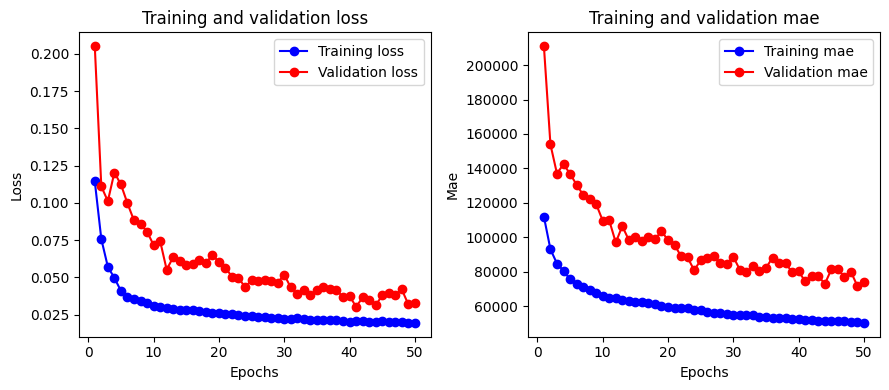

(<keras.engine.functional.Functional at 0x7f6cd2f6f580>,
 <keras.callbacks.History at 0x7f6cd2e96be0>)

In [ ]:
# LSTM 32
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [32],
    "dropout": (0.,0.,0.),
    "regulatization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1248      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 18s 4ms/step - loss: 0.1061 - mae: 0.2057 - val_loss: 0.1402 - val_mae: 0.2835
Epoch 2/50
4365/4365 [==============================] - 16s 4ms/step - loss: 0.0663 - mae: 0.1663 - val_loss: 0.0950 - val_mae: 0.2391
Epoch 3/50
4365/4365 [===========================

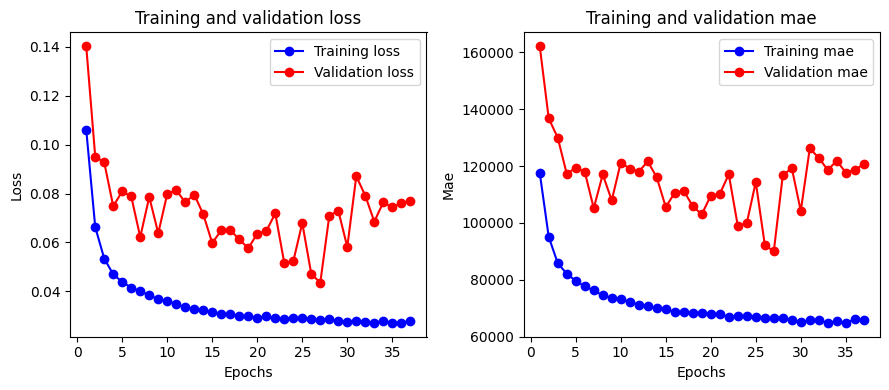

(<keras.engine.functional.Functional at 0x7f6cd1935ac0>,
 <keras.callbacks.History at 0x7f6cd18e09a0>)

In [ ]:
# RNN 32
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 gru (GRU)                   (None, 32)                3840      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,873
Trainable params: 3,873
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 31s 6ms/step - loss: 0.1108 - mae: 0.1958 - val_loss: 0.1133 - val_mae: 0.2528
Epoch 2/50
4365/4365 [==============================] - 25s 6ms/step - loss: 0.0593 - mae: 0.1507 - val_loss: 0.0566 - val_mae: 0.1689
Epoch 3/50
4365/4365 [===========================

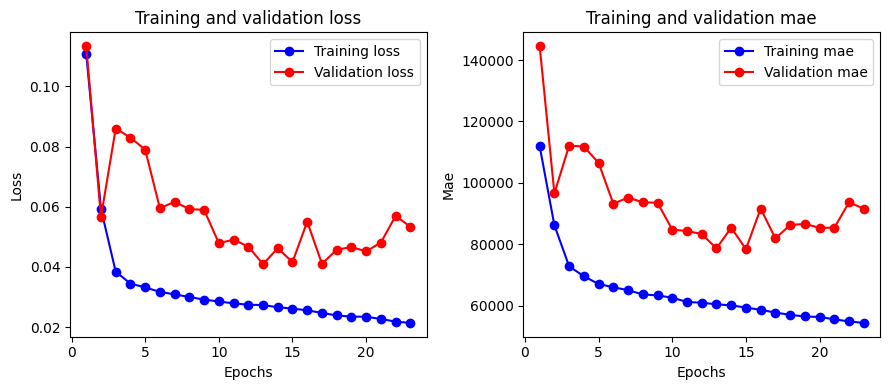

(<keras.engine.functional.Functional at 0x7f6cd479f610>,
 <keras.callbacks.History at 0x7f6cd4758e20>)

In [ ]:
# GRU 32
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### single rnn (64)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 18,241
Trainable params: 18,241
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 27s 5ms/step - loss: 0.1071 - mae: 0.1935 - val_loss: 0.2294 - val_mae: 0.3790
Epoch 2/50
4365/4365 [==============================] - 23s 5ms/step - loss: 0.0600 - mae: 0.1522 - val_loss: 0.1819 - val_mae: 0.3248
Epoch 3/50
4365/4365 [=========================

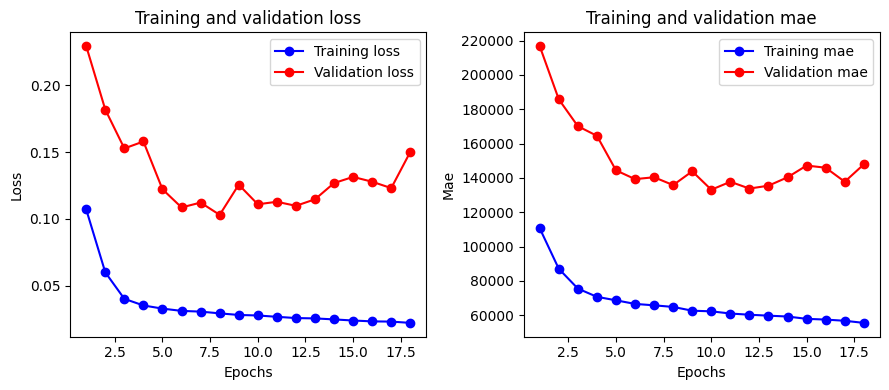

(<keras.engine.functional.Functional at 0x7f24c82d6dc0>,
 <keras.callbacks.History at 0x7f24c8390c70>)

In [ ]:
# LSTM 64
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [64],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                4544      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 41s 9ms/step - loss: 0.1060 - mae: 0.2153 - val_loss: 0.3092 - val_mae: 0.4513
Epoch 2/50
4365/4365 [==============================] - 40s 9ms/step - loss: 0.0796 - mae: 0.1841 - val_loss: 0.3311 - val_mae: 0.4796
Epoch 3/50
4365/4365 [===========================

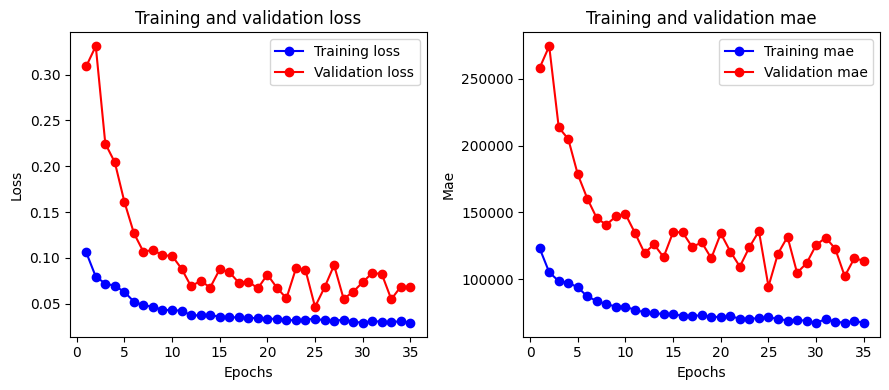

(<keras.engine.functional.Functional at 0x7f2445dacc40>,
 <keras.callbacks.History at 0x7f2445d45250>)

In [ ]:
# RNN 64
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 gru (GRU)                   (None, 64)                13824     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,889
Trainable params: 13,889
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 23s 5ms/step - loss: 0.1077 - mae: 0.1996 - val_loss: 0.1466 - val_mae: 0.2995
Epoch 2/50
4365/4365 [==============================] - 20s 5ms/step - loss: 0.0439 - mae: 0.1393 - val_loss: 0.1155 - val_mae: 0.2565
Epoch 3/50
4365/4365 [=========================

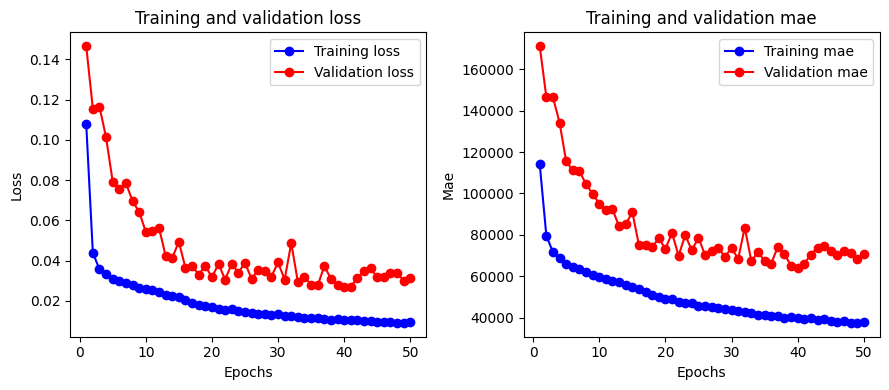

(<keras.engine.functional.Functional at 0x7f2447f36520>,
 <keras.callbacks.History at 0x7f2447eee790>)

In [ ]:
# GRU 64
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### simple RNN (128)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               69120     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,249
Trainable params: 69,249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 32s 7ms/step - loss: 0.1052 - mae: 0.1955 - val_loss: 0.1966 - val_mae: 0.3459
Epoch 2/50
4365/4365 [==============================] - 30s 7ms/step - loss: 0.0472 - mae: 0.1428 - val_loss: 0.1473 - val_mae: 0.2887
Epoch 3/50
4365/4365 [=========================

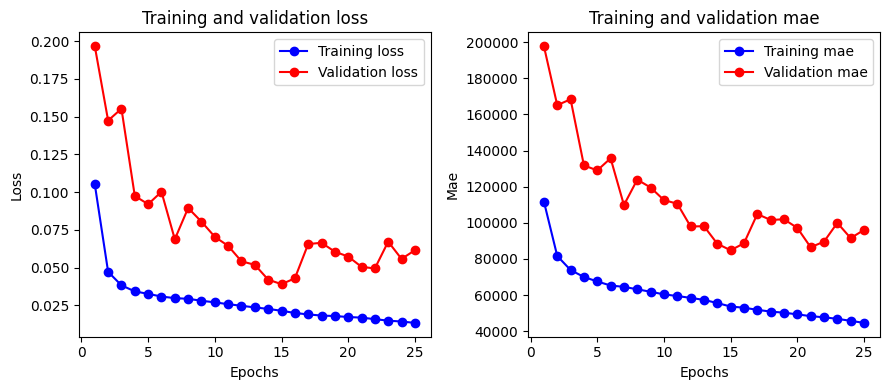

(<keras.engine.functional.Functional at 0x7f6cd4513c10>,
 <keras.callbacks.History at 0x7f6cd4445490>)

In [ ]:
# LSTM 32
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [128],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               17280     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,409
Trainable params: 17,409
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 18s 4ms/step - loss: 0.1303 - mae: 0.2461 - val_loss: 0.2716 - val_mae: 0.4221
Epoch 2/50
4365/4365 [==============================] - 18s 4ms/step - loss: 0.0927 - mae: 0.1965 - val_loss: 0.2448 - val_mae: 0.4129
Epoch 3/50
4365/4365 [=========================

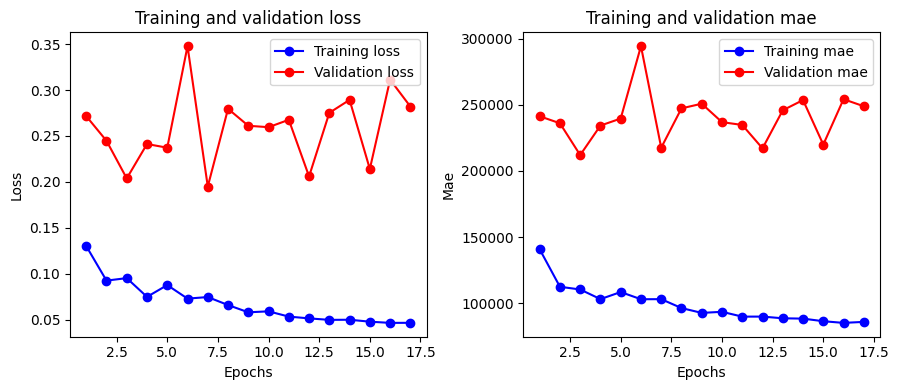

(<keras.engine.functional.Functional at 0x7f6cd065d6d0>,
 <keras.callbacks.History at 0x7f6cd2da37f0>)

In [ ]:
# RNN 128
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 gru (GRU)                   (None, 128)               52224     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 52,353
Trainable params: 52,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 39s 8ms/step - loss: 0.0978 - mae: 0.1941 - val_loss: 0.1682 - val_mae: 0.3238
Epoch 2/50
4365/4365 [==============================] - 32s 7ms/step - loss: 0.0409 - mae: 0.1328 - val_loss: 0.1274 - val_mae: 0.2650
Epoch 3/50
4365/4365 [=========================

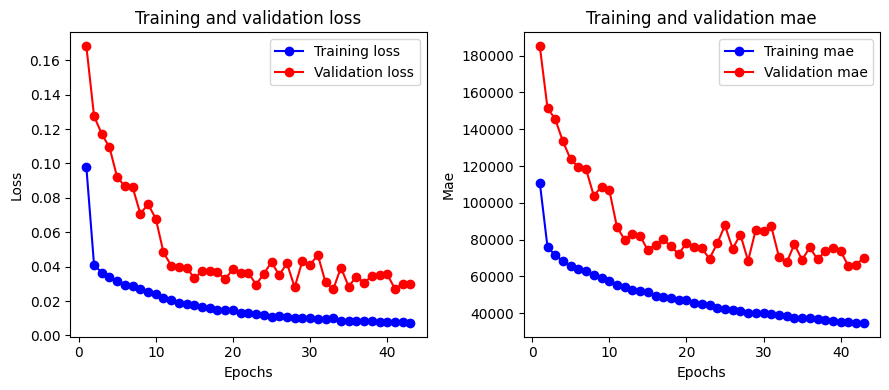

(<keras.engine.functional.Functional at 0x7fdd2fb2bdc0>,
 <keras.callbacks.History at 0x7fdd2ca90070>)

In [ ]:
# GRU 128
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### 2 staked recurrent layers (32,32)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 lstm_1 (LSTM)               (None, 8, 32)             4992      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,345
Trainable params: 13,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 35s 7ms/step - loss: 0.1118 - mae: 0.1980 - val_loss: 0.3119 - val_mae: 0.4617
Epoch 2/50
4365/4365 [============================

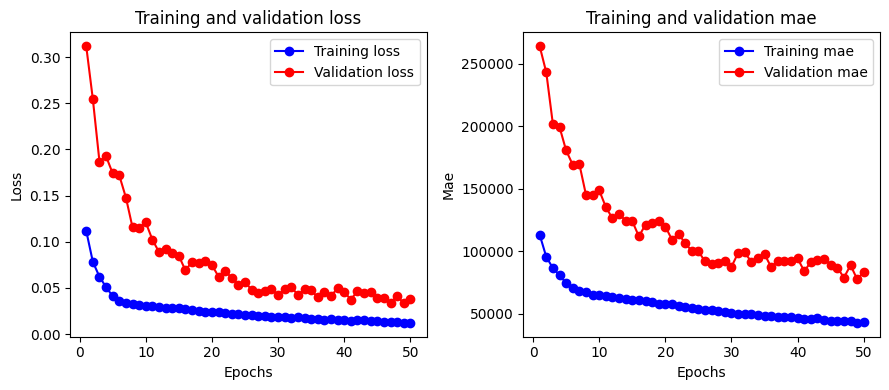

(<keras.engine.functional.Functional at 0x7f2445ef4070>,
 <keras.callbacks.History at 0x7f24dbe849a0>)

In [ ]:
# LSTM 32 and 32
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [32,32],
    "regularization": (0.,0.),
    "dropout": (0.,0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8, 32)             1248      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,361
Trainable params: 3,361
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 84s 19ms/step - loss: 0.0976 - mae: 0.2067 - val_loss: 0.2292 - val_mae: 0.3874
Epoch 2/50
4365/4365 [=============================

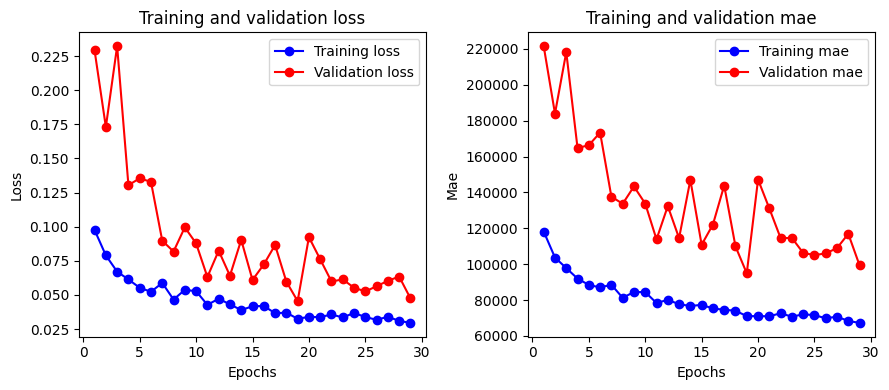

(<keras.engine.functional.Functional at 0x7f24472f9a90>,
 <keras.callbacks.History at 0x7f2445d63f40>)

In [ ]:
# RNN 32 and 32
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 gru_1 (GRU)                 (None, 8, 32)             3840      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,209
Trainable params: 10,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 31s 6ms/step - loss: 0.1016 - mae: 0.1916 - val_loss: 0.1182 - val_mae: 0.2611
Epoch 2/50
4365/4365 [============================

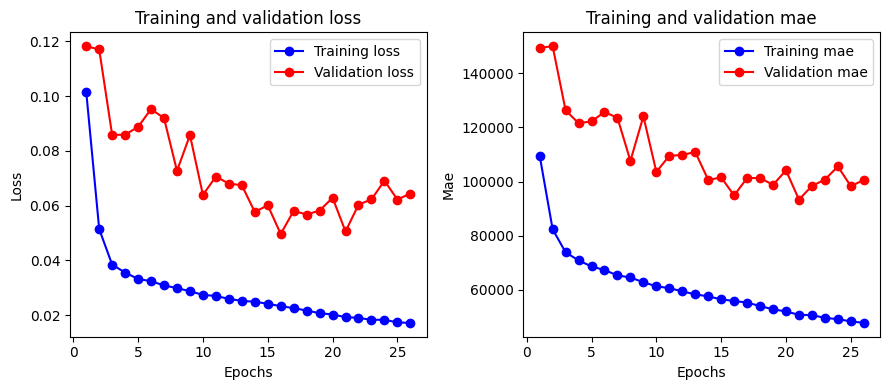

(<keras.engine.functional.Functional at 0x7f244635b9a0>,
 <keras.callbacks.History at 0x7f24462b3550>)

In [ ]:
# GRU 32 and 32
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### 2 staked recurrent layers (64,64)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 lstm_5 (LSTM)               (None, 8, 64)             18176     
                                                                 
 lstm_6 (LSTM)               (None, 64)                33024     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 51,265
Trainable params: 51,265
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 40s 8ms/step - loss: 0.1145 - mae: 0.2003 - val_loss: 0.3060 - val_mae: 0.4346
Epoch 2/50
4365/4365 [============================

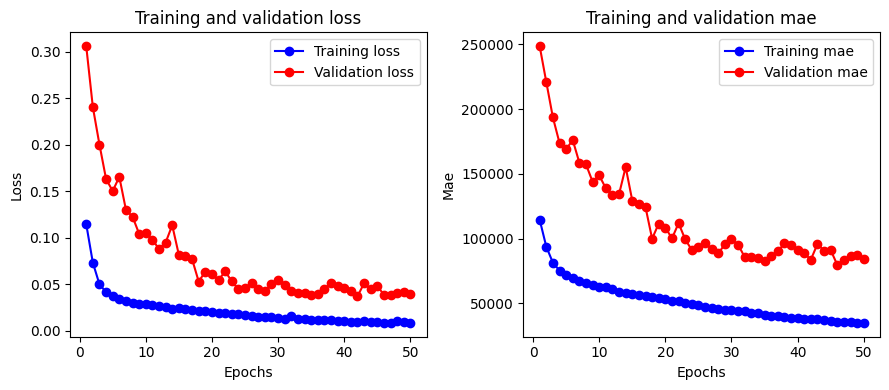

(<keras.engine.functional.Functional at 0x7f2445432f40>,
 <keras.callbacks.History at 0x7f244537d700>)

In [ ]:
# LSTM 64 and 64
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.LSTM,
    "cell_units": [64,64],
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)


Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 8, 64)             4544      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,865
Trainable params: 12,865
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 25s 5ms/step - loss: 0.1410 - mae: 0.2348 - val_loss: 0.4763 - val_mae: 0.5764
Epoch 2/50
4365/4365 [============================

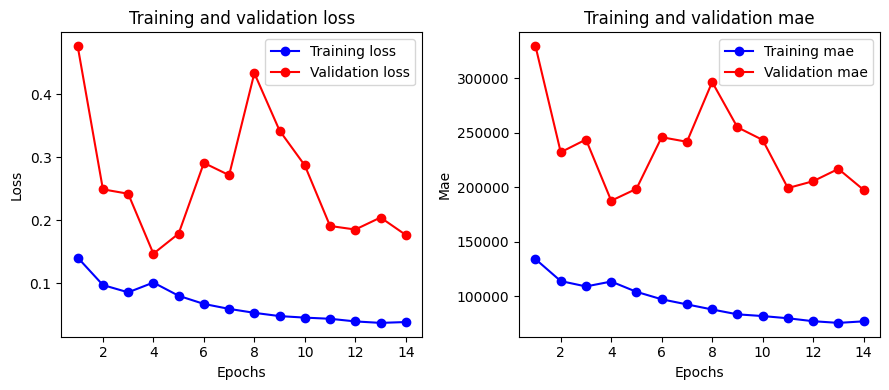

(<keras.engine.functional.Functional at 0x7fdd2e09eb20>,
 <keras.callbacks.History at 0x7fdd2e054ca0>)

In [ ]:
# RNN 64 and 64
hyperparameters["recurrent_unit"] = layers.SimpleRNN 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 gru_1 (GRU)                 (None, 8, 64)             13824     
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 38,849
Trainable params: 38,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 49s 10ms/step - loss: 0.1040 - mae: 0.1954 - val_loss: 0.2335 - val_mae: 0.3716
Epoch 2/50
4365/4365 [===========================

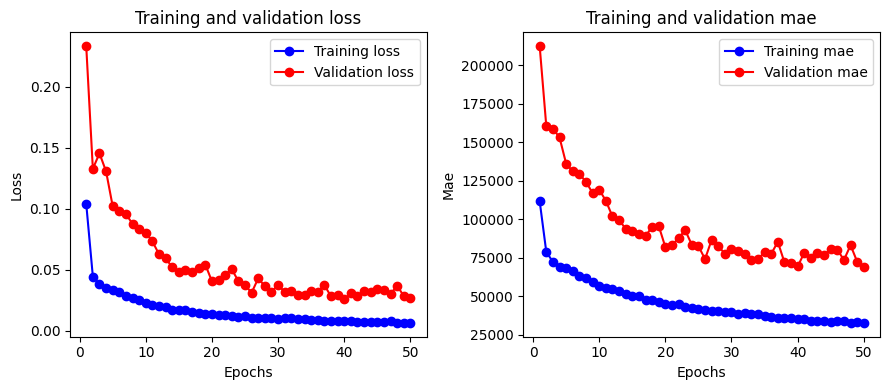

(<keras.engine.functional.Functional at 0x7fdd2db3d9d0>,
 <keras.callbacks.History at 0x7fdd2db3da30>)

In [ ]:
# GRU 64 and 64
hyperparameters["recurrent_unit"] = layers.GRU 
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### Aditional architecture changes

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 gru (GRU)                   (None, 64)                13824     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 13,889
Trainable params: 13,889
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 33s 6ms/step - loss: 0.1087 - mae: 0.2034 - val_loss: 0.1935 - val_mae: 0.3427
Epoch 2/50
4365/4365 [==============================] - 30s 7ms/step - loss: 0.0584 - mae: 0.1614 - val_loss: 0.1928 - val_mae: 0.3520
Epoch 3/50
4365/4365 [=========================

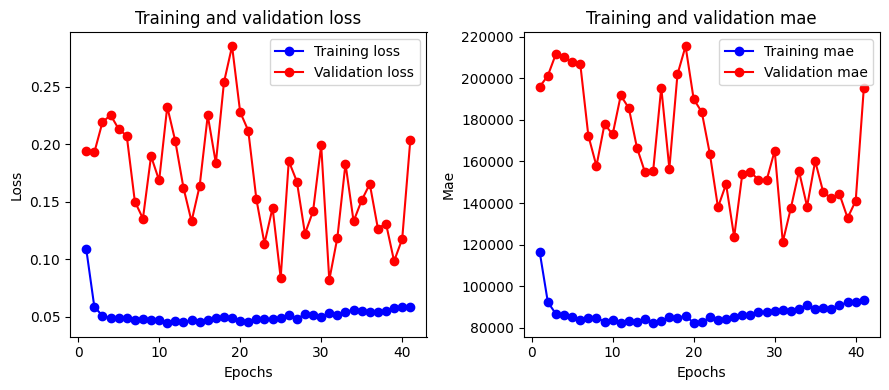

(<keras.engine.functional.Functional at 0x7f797f15fdc0>,
 <keras.callbacks.History at 0x7f797f054e50>)

In [ ]:
# lr - LSTM 64
hyperparameters = {
    "epochs": 50,
    "lr": 0.01,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "hidden_layer": None,
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                13824     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,889
Trainable params: 13,889
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================] - 24s 5ms/step - loss: 0.1059 - mae: 0.2007 - val_loss: 0.0718 - val_mae: 0.1952
Epoch 2/50
4365/4365 [==============================] - 22s 5ms/step - loss: 0.0420 - mae: 0.1384 - val_loss: 0.0656 - val_mae: 0.1686
Epoch 3/50
4365/4365 [=========================

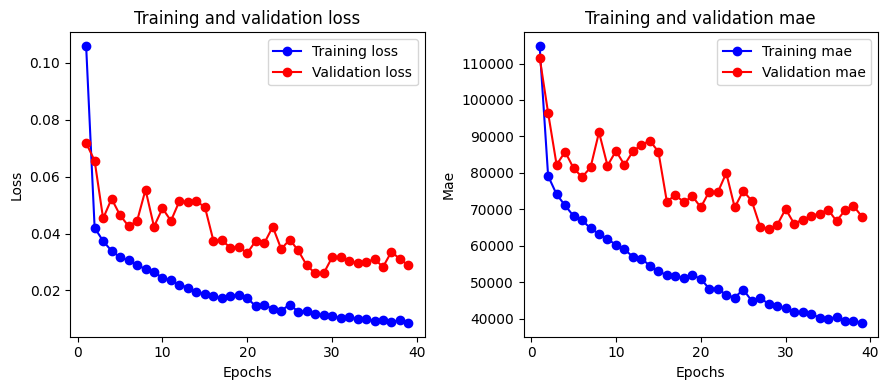

(<keras.engine.functional.Functional at 0x7f798be0baf0>,
 <keras.callbacks.History at 0x7f798bdabd30>)

In [ ]:
# ADAM - LSTM 64
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.Adam,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],å
    "dropout": (0.,0.,0.),
    "regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8, 6)]            0         
                                                                 
 gru_3 (GRU)                 (None, 64)                13824     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 15,937
Trainable params: 15,937
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4365/4365 [==============================]

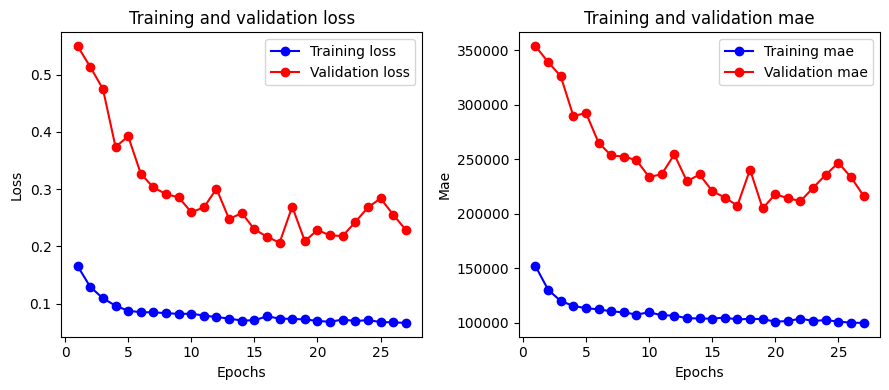

(<keras.engine.functional.Functional at 0x7f7895a1d4f0>,
 <keras.callbacks.History at 0x7f7895a0f970>)

In [ ]:
# GRU 64 - dense hidden layer 32
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0.2,0.2,0.2),
    "hidden_layer": 32,
    "regularization": (0.,0.),
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)


### Different sequence lengths

Be careful not to set a very large sequence size, since the teset will run out of samples to generate sequences (at 20%).


Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 6)]            0         
                                                                 
 gru_1 (GRU)                 (None, 64)                13824     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,889
Trainable params: 13,889
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4725/4725 [==============================] - 21s 4ms/step - loss: 0.1193 - mae: 0.2058 - val_loss: 0.1204 - val_mae: 0.2597
Epoch 2/100
4725/4725 [==============================] - 18s 4ms/step - loss: 0.0667 - mae: 0.1644 - val_loss: 0.1320 - val_mae: 0.2765
Epoch 3/100
4725/4725 [======================

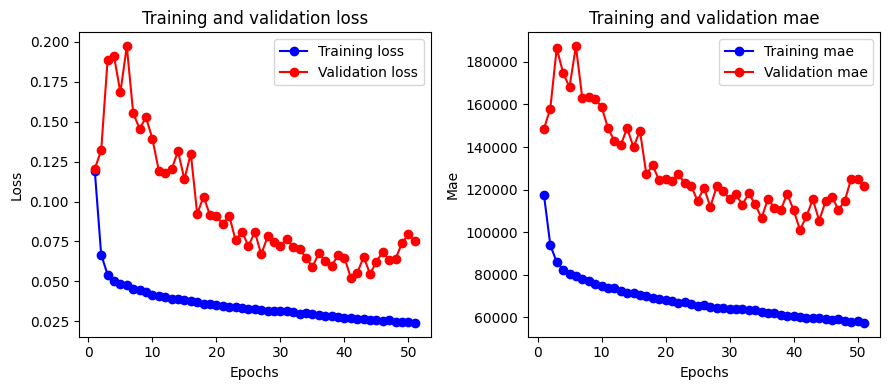

(<keras.engine.functional.Functional at 0x7fa0cad7aaf0>,
 <keras.callbacks.History at 0x7fa0cad7a220>)

In [ ]:
# GRU 64 - 4 seq len
hyperparameters = {
    "epochs": 100,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64],
    "dropout": (0,0,0),
    "regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 gru_7 (GRU)                 (None, 128)               52224     
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 52,353
Trainable params: 52,353
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4005/4005 [==============================] - 32s 8ms/step - loss: 0.0973 - mae: 0.1917 - val_loss: 0.0801 - val_mae: 0.2020
Epoch 2/100
4005/4005 [==============================] - 29s 7ms/step - loss: 0.0411 - mae: 0.1333 - val_loss: 0.0947 - val_mae: 0.2147
Epoch 3/100
4005/4005 [======================

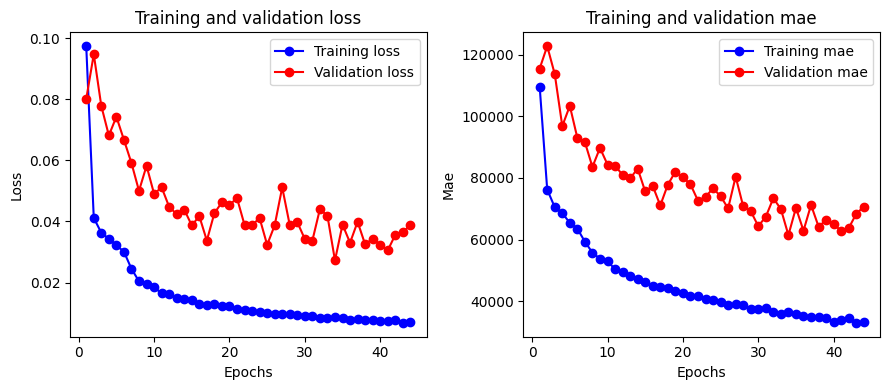

(<keras.engine.functional.Functional at 0x7f57d13818b0>,
 <keras.callbacks.History at 0x7f57d1834880>)

In [ ]:
# GRU 128 - 12 seq len 
hyperparameters = {
    "epochs": 100,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [128],
    "dropout": (0,0,0),
    "regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

### Best configurations - 2 GRU - 12 sequence lenght 

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 12, 6)]           0         
                                                                 
 gru_10 (GRU)                (None, 12, 32)            3840      
                                                                 
 gru_11 (GRU)                (None, 32)                6336      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,209
Trainable params: 10,209
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4005/4005 [==============================] - 52s 12ms/step - loss: 0.1064 - mae: 0.1910 - val_loss: 0.1466 - val_mae: 0.2790
Epoch 2/100
4005/4005 [=========================

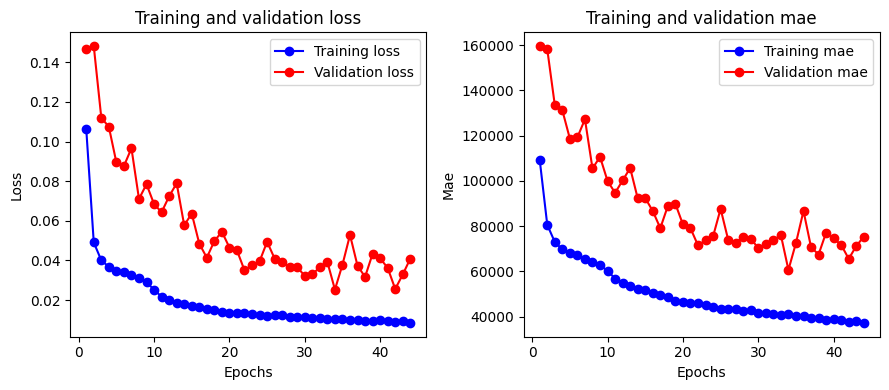

(<keras.engine.functional.Functional at 0x7f57cd4dcb50>,
 <keras.callbacks.History at 0x7f57d3958040>)

In [ ]:
hyperparameters = {
    "epochs": 100,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [32,32],
    "dropout": (0,0,0),
    "regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 gru_8 (GRU)                 (None, 12, 64)            13824     
                                                                 
 gru_9 (GRU)                 (None, 64)                24960     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 38,849
Trainable params: 38,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4005/4005 [==============================] - 54s 12ms/step - loss: 0.1031 - mae: 0.1986 - val_loss: 0.1693 - val_mae: 0.3032
Epoch 2/100
4005/4005 [=========================

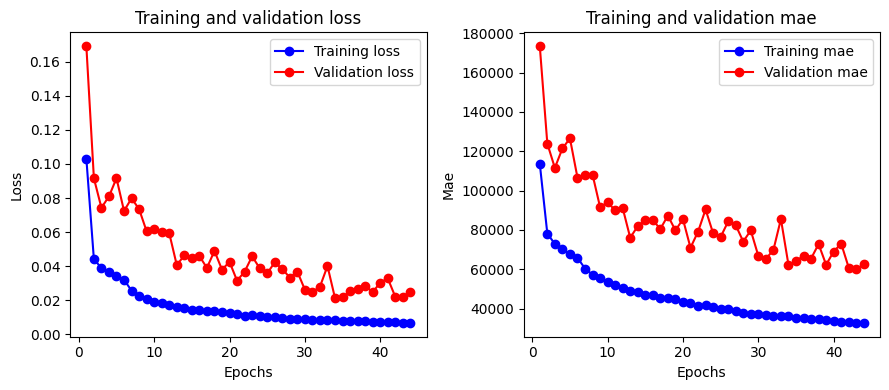

(<keras.engine.functional.Functional at 0x7f57d179be80>,
 <keras.callbacks.History at 0x7f57d141d760>)

In [ ]:
hyperparameters = {
    "epochs": 100,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [64,64],
    "dropout": (0,0,0),
    "regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 gru (GRU)                   (None, 12, 128)           52224     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 151,425
Trainable params: 151,425
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4005/4005 [==============================] - 90s 22ms/step - loss: 0.1016 - mae: 0.1963 - val_loss: 0.0762 - val_mae: 0.1906
Epoch 2/100
4005/4005 [=======================

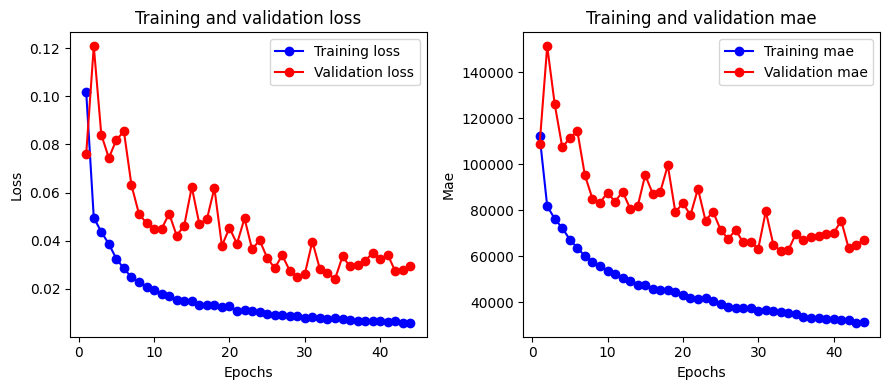

(<keras.engine.functional.Functional at 0x7fd48da1e220>,
 <keras.callbacks.History at 0x7fd47e97db20>)

In [ ]:
hyperparameters = {
    "epochs": 100,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [128,128],
    "dropout": (0,0,0),
    "regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 12, 6)]           0         
                                                                 
 gru_12 (GRU)                (None, 12, 256)           202752    
                                                                 
 gru_13 (GRU)                (None, 256)               394752    
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 597,761
Trainable params: 597,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4005/4005 [==============================] - 104s 25ms/step - loss: 0.1146 - mae: 0.2053 - val_loss: 0.1299 - val_mae: 0.2477
Epoch 2/100
4005/4005 [======================

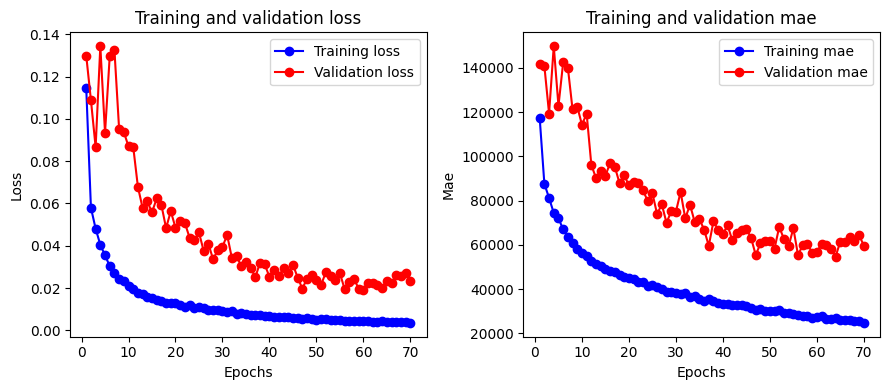

(<keras.engine.functional.Functional at 0x7f57d3951790>,
 <keras.callbacks.History at 0x7f57d3951730>)

In [ ]:
hyperparameters = {
    "epochs": 100,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [256,256],
    "dropout": (0,0,0),
    "regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

## Overfitting mitigation

Given the best architectures, we will try to reduce the performance difference between the train and validation set in order to reduce overtraining.

In essence, we will start from the architecture with the best error in train (greater margin of improvement), in this case, it also coincides with the one with the lowest error in validation. Remember that this configuration will be using sequences of 12.

In relation to the techniques proposed, essentially **dropout** and **weight regularization** will be used. Techniques such as data augmentation have not been considered since the available data are considered to be more than sufficient. As for **batch normalization**, this technique is not used with this kind of recurrent networks (https://arxiv.org/abs/1510.01378).

Finally, it should be noted that techniques such as lr decay have been tested and, for reasons of simplicity, it has been preferred not to deal with them because of their null contribution.

#### Dropout

Both dropout of the inputs and dropout of the recurrent state have been considered. Also, dropout before the final dense layer has been tested. In general, we have observed the following phenomena:

- Excessively slow workouts due to lack of cuDNN acceleration.
- Dropout tends to introduce too much noise in the network.

In [ ]:
# GRU 256,256 - dropout
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [256,256],
    "dropout": (0.1,0.1,0.1),
    "regularization": (0.,0.),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 gru (GRU)                   (None, 12, 256)           202752    
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 597,761
Trainable params: 597,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4005/4005 [=============================

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 gru (GRU)                   (None, 12, 256)           202752    
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 597,761
Trainable params: 597,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4005/4005 [=============================

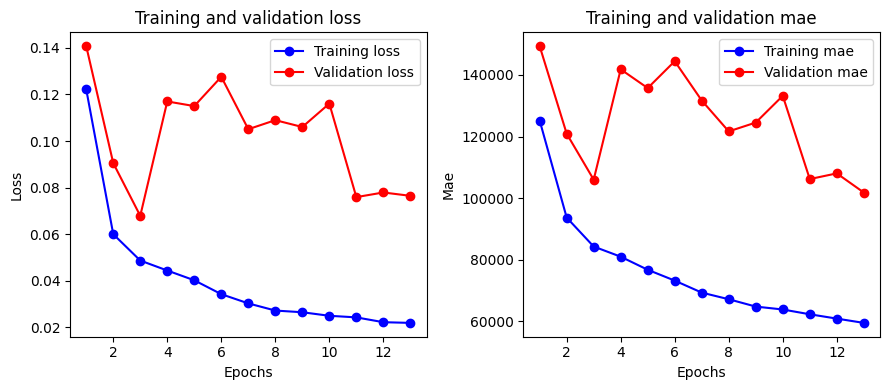

(<keras.engine.functional.Functional at 0x7fdf1c0d1670>,
 <keras.callbacks.History at 0x7fdf1c0d5760>)

In [ ]:
# GRU 256,256 - less dropout
hyperparameters["dropout"] = (0,0.05,0.5)
execute_pipeline(trainData, testData, hyperparameters, stdSales)

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 gru (GRU)                   (None, 12, 256)           202752    
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 597,761
Trainable params: 597,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 380s 92ms/step - loss: 0.1157 - mae: 0.2110 - val_loss: 0.2274 - val_mae: 0.3474
Epoch 2/50
4005/4005 [========================

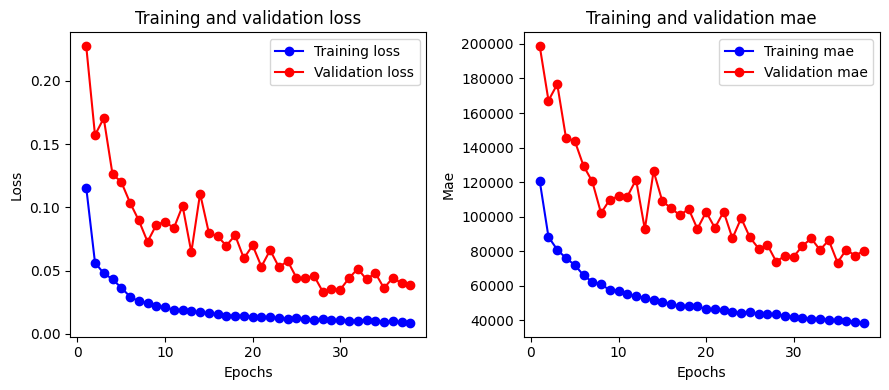

(<keras.engine.functional.Functional at 0x7fb31e264760>,
 <keras.callbacks.History at 0x7fb31e1fd760>)

In [ ]:
# GRU 256,256 - even less dropout
hyperparameters["dropout"] = (0,0.05,0)
execute_pipeline(trainData, testData, hyperparameters, stdSales)

#### Weight regularization

Model: "rnn_sales"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 6)]           0         
                                                                 
 gru (GRU)                   (None, 12, 256)           202752    
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 597,761
Trainable params: 597,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4005/4005 [==============================] - 143s 35ms/step - loss: 0.1452 - mae: 0.2097 - val_loss: 0.1991 - val_mae: 0.3302
Epoch 2/50
4005/4005 [========================

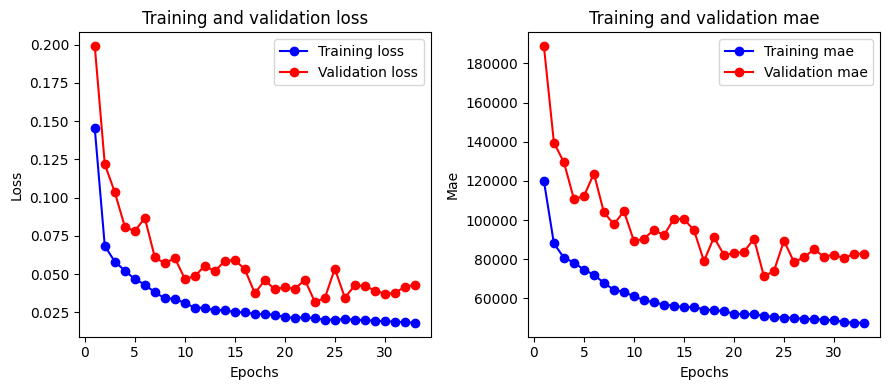

(<keras.engine.functional.Functional at 0x7fa258b229d0>,
 <keras.callbacks.History at 0x7fa25ac10be0>)

In [ ]:
# GRU 256,256 - dropout & regularization
hyperparameters = {
    "epochs": 50,
    "lr": 0.001,
    "optimizer": optimizers.RMSprop,
    "recurrent_unit": layers.GRU,
    "cell_units": [256,256],
    "dropout": (0.,0.,0.),
    "regularization": (1e-5,1e-4),
    "hidden_layer": None,
    "lr_scheduler": None,
    "early_stop": EarlyStopping(monitor='val_loss', patience=10),
    "checkpoint": None
}
execute_pipeline(trainData, testData, hyperparameters, stdSales)

# 4. Results

As can be seen from the different runs, we have started from simple to complex models. First of all, observations will be treated for the initial contact with simpler architectures (only one recurrent cell) and sequence sizes of 8. Models using SimpleRNN recurrent units have a clearly lower performance than the rest. Also, while the performance of the LSTMs may be slightly better for the smallest architecture tested (32 neurons in recurrent cell), for the rest of the runs the GRUs excel, far outperforming the other models. Specifically, the best result obtained with these first models has been with the 64-neuron GRU. This has managed to obtain MAE values close to 64,000 in the validation set.

With the simplest architectures executed and the contact made, we continued testing architectures with two stacked recurrent cells. With these fast runs, it was possible to conclude that they do not provide any improvement, the best result obtained in validation being a MAE of 68622.57. Again, the LSTM performs better with a lower number of neurons, reaching better values only with GRUs and a higher number of neurons (higher than 32).

With the execution of more complex models and the non-improvement of results, it can be verified that the complexity of the first models coincides with the complexity of the problem to be solved. In other words, the models with 2 recurrent units obtain a slightly lower error in training than models with a single recurrent unit (around 32595 vs. 34711 approximately). However, the errors in validation are the reverse and therefore a sign of overfitting of the network to the train set. This is an indication that the most suitable architecture will be simpler for sequence lengths of 8.

Additionally, multiple runs have been performed with different variations in model hyperparameters. We have modified learning rates, used lr schedulers, used different optimization algorithms, even used a more complex hidden dense layer classifier. All of this without any improvement.

The last step prior to the use of regularization techniques has been to use different sequence sizes. Smaller sequences have been tested, with worse results. But also longer sequences have been used, specifically almost the maximum allowed by the length of the test set, 12. With the use of longer sequences, it has been decided to use a slightly more complex model and, in order to obtain better results (61417.20 MAE in validation) than the best ones obtained so far, we have proceeded to run again the most interesting architectures so far, the GRUs.

The runs with this sequence size of 12 have unquestionably demonstrated that the best model is a GRU of two stacked recurrent units of 256 neurons each. This network has been able to reach the lowest values in a really stable way until now, being its minimum MAE in validation of 56442.06. Note that other architectures with GRU and this sequence size have been tested, however, for the sake of clarity and simplicity we show only 4 runs with an incremental stacked recurrent memory size.

Starting with the regularization process, we will try to reduce the difference between train and validation performance. That is, we will try to improve the inference capability by mitigating the overfitting to the training set. Since the best model in validation (GRU 256,256) is also the model with the lowest error in training, we will focus only on this one for the overfit mitigation stage.

Finally, the results obtained in the regularization phase have not been good. The techniques have only induced a higher train error, without improving the validation metrics and consequently the generalization capacity.

# 5. Conclusions

The main conclusion that can be drawn is related to the amount of data and the problem itself.  It can be seen in the learning graphs that the networks learn for a large number of epochs without overfitting, which is reflected in the validation set (on the contrary, in part 2 of the practice, very early overfitting occurs due to the small amount of data).

As no overfitting occurs, in multiple rounds the model manages to learn (more than 20 even for the worst models), therefore, the tested techniques do not manage to improve values. This is because the training was already correct and the dropout and regularization introduced a greater difficulty in learning.

Additionally, it should be noted that with the increase in sequence length, the simplest models of a single recurrent cell have ceased to be the best adapted to the problem, and subsequently, with length 12, considerably more complex models have become the most suitable.

Finally, it should be noted that bidirectional networks have not been used, since they do not make sense for the problem to be solved, where the closer the data are to the end of the sequence, the more important they are.
